# EDA: Anomaly Scores (time-aware)

This notebook explores the `Anomaly Scores` target as a **regression** problem using the shared time-aware split (`split_time_70_15_15.csv`).

Charts use `config/visualization.json` → `visualization.color_palette` via the `COLOR_PALLETE` variable.

In [1]:
from __future__ import annotations

import json
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from cycler import cycler
from matplotlib import pyplot as plt

SEED = 42
np.random.seed(SEED)

# Resolve repo root robustly so this works from notebooks/.
cwd = Path.cwd().resolve()
candidates = [cwd] + list(cwd.parents)
REPO_ROOT = next((p for p in candidates if (p / 'src').exists() and (p / 'data').exists()), None)
if REPO_ROOT is None:
    raise FileNotFoundError('Could not locate repo root (expected src/ and data/).')
sys.path.insert(0, str(REPO_ROOT))

PREPROCESSED_ROOT = REPO_ROOT / 'data' / '02-preprocessed'
VIZ_CONFIG_JSON = REPO_ROOT / 'config' / 'visualization.json'
REPORTS_DIR = REPO_ROOT / 'reports' / 'anomaly_scores'
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

prepared_dirs = sorted([p for p in PREPROCESSED_ROOT.iterdir() if p.is_dir()], key=lambda p: p.name)
if not prepared_dirs:
    raise FileNotFoundError(f'No prepared datasets found under: {PREPROCESSED_ROOT}')
DATASET_DIR = prepared_dirs[-1]

cleaned_parquet = DATASET_DIR / 'cleaned.parquet'
cleaned_csv = DATASET_DIR / 'cleaned.csv'
split_time_csv = DATASET_DIR / 'split_time_70_15_15.csv'

print(f'Using prepared dataset: {DATASET_DIR.name}')
print(f'Using time split:      {split_time_csv.name}')

if cleaned_parquet.exists():
    df = pd.read_parquet(cleaned_parquet)
elif cleaned_csv.exists():
    df = pd.read_csv(cleaned_csv)
else:
    raise FileNotFoundError('Expected cleaned.parquet or cleaned.csv')

if not split_time_csv.exists():
    raise FileNotFoundError(f'Missing time-aware split artifact: {split_time_csv}')
splits = pd.read_csv(split_time_csv)

def load_color_palette(path: Path) -> list[str]:
    payload = json.loads(path.read_text(encoding='utf-8'))
    palette = payload.get('visualization', {}).get('color_palette', [])
    if not isinstance(palette, list) or not palette:
        raise ValueError(f'Missing/invalid visualization.color_palette in {path}')
    return [str(c) for c in palette]

COLOR_PALLETE = load_color_palette(VIZ_CONFIG_JSON)
plt.rcParams['axes.prop_cycle'] = cycler(color=COLOR_PALLETE)
print(f'Loaded COLOR_PALLETE ({len(COLOR_PALLETE)} colors) from {VIZ_CONFIG_JSON.name}')

required = {'row_id', 'Timestamp', 'Anomaly Scores'}
missing = required - set(df.columns)
if missing:
    raise KeyError(f'Missing required columns in cleaned data: {sorted(missing)}')

df = df.merge(splits[['row_id', 'split']], on='row_id', how='left')
if df['split'].isna().any():
    raise ValueError('Some rows are missing split assignments (time split join failed)')

df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce', utc=True)
df['Anomaly Scores'] = pd.to_numeric(df['Anomaly Scores'], errors='coerce')

print('Rows:', df.shape[0])
print('Timestamp missing:', int(df['Timestamp'].isna().sum()))
print('Anomaly Scores missing:', int(df['Anomaly Scores'].isna().sum()))

Using prepared dataset: cybersecurity_attacks_v1_2025-12-29
Using time split:      split_time_70_15_15.csv
Loaded COLOR_PALLETE (9 colors) from visualization.json
Rows: 40000
Timestamp missing: 0
Anomaly Scores missing: 0


In [2]:
# Summary stats (overall + by split)

display(df[['Anomaly Scores']].describe())
display(df.groupby('split')['Anomaly Scores'].describe())

,Anomaly Scores
count,40000.000000
mean,50.113473
std,28.853598
min,0.000000
25%,25.150000
50%,50.345000
75%,75.030000
max,100.000000


,count,mean,std,min,25%,50%,75%,max
split,,,,,,,,
test,6000.0,50.372350,28.909092,0.0,25.1775,50.49,75.2175,99.99
train,28000.0,50.075863,28.826157,0.0,25.2000,50.40,74.9725,99.99
val,6000.0,50.030113,28.929379,0.0,24.9600,49.94,75.1300,100.00


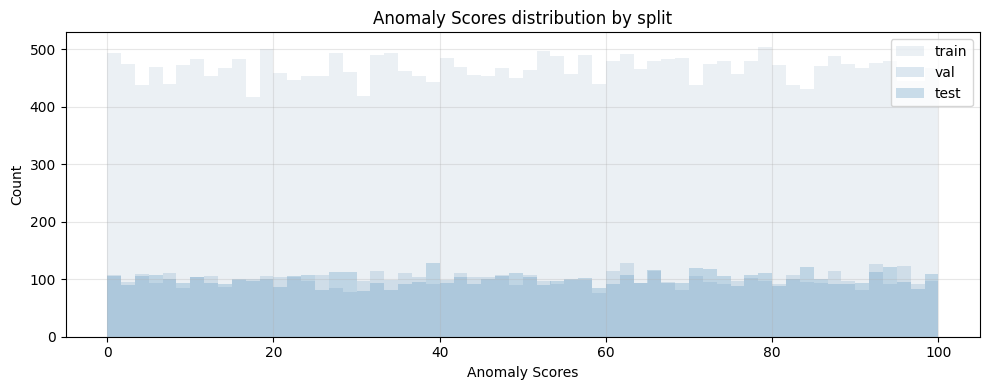

Saved: C:\repos\ml-cybersecurity_attacks\reports\anomaly_scores\anomaly_scores_hist_by_split.png


In [3]:
# Chart 1: Target distribution by split (hist overlays)

fig, ax = plt.subplots(figsize=(10, 4))
bins = 60
for i, split_name in enumerate(['train', 'val', 'test']):
    series = df.loc[df['split'].eq(split_name), 'Anomaly Scores'].dropna()
    ax.hist(series, bins=bins, alpha=0.35, label=split_name, color=COLOR_PALLETE[i % len(COLOR_PALLETE)])

ax.set_title('Anomaly Scores distribution by split')
ax.set_xlabel('Anomaly Scores')
ax.set_ylabel('Count')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
out = REPORTS_DIR / 'anomaly_scores_hist_by_split.png'
plt.savefig(out, dpi=160)
plt.show()
print(f'Saved: {out}')

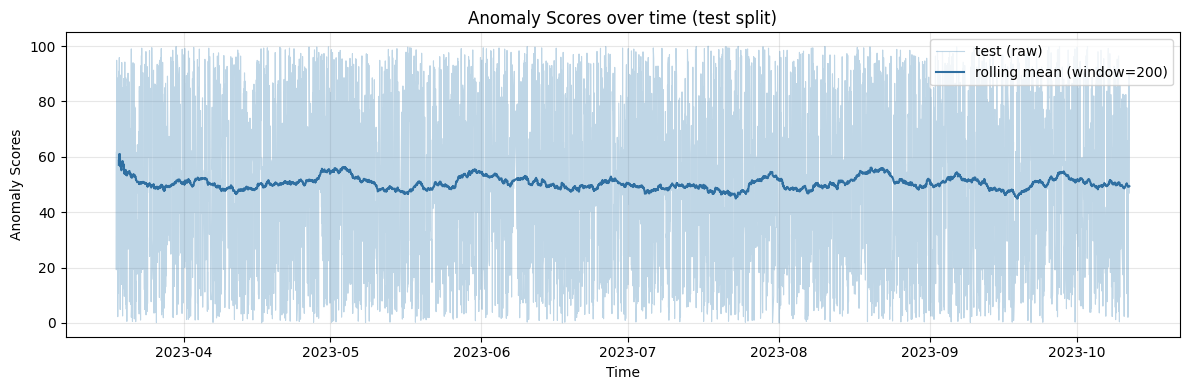

Saved: C:\repos\ml-cybersecurity_attacks\reports\anomaly_scores\anomaly_scores_over_time_test.png


In [4]:
# Chart 2: Anomaly Scores over time (test split; rolling mean)

df_test = df.loc[df['split'].eq('test'), ['Timestamp', 'Anomaly Scores']].dropna()
df_test = df_test.sort_values('Timestamp').reset_index(drop=True)

window = 200
rolling = df_test['Anomaly Scores'].rolling(window=window, min_periods=max(20, window // 10)).mean()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_test['Timestamp'], df_test['Anomaly Scores'], linewidth=0.8, alpha=0.35, color=COLOR_PALLETE[3], label='test (raw)')
ax.plot(df_test['Timestamp'], rolling, linewidth=1.5, color=COLOR_PALLETE[4], label=f'rolling mean (window={window})')
ax.set_title('Anomaly Scores over time (test split)')
ax.set_xlabel('Time')
ax.set_ylabel('Anomaly Scores')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
out = REPORTS_DIR / 'anomaly_scores_over_time_test.png'
plt.savefig(out, dpi=160)
plt.show()
print(f'Saved: {out}')

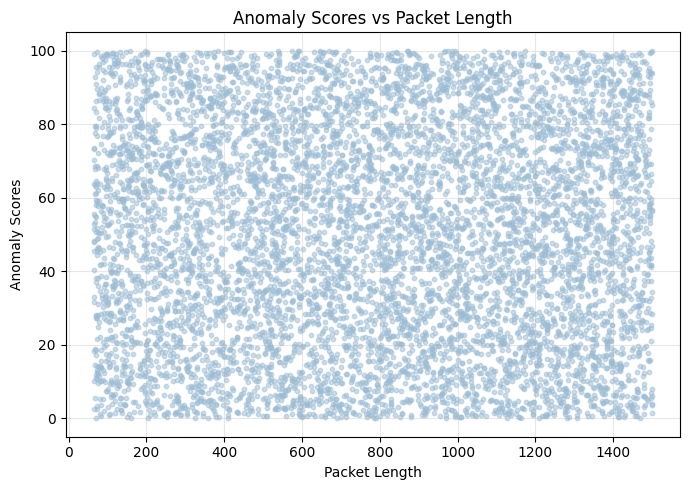

Saved: C:\repos\ml-cybersecurity_attacks\reports\anomaly_scores\anomaly_scores_vs_packet_length.png


In [5]:
# Chart 3: Relationship to a numeric predictor (Packet Length) if present

col = 'Packet Length'
if col not in df.columns:
    print(f'Skipping: {col} not present')
else:
    x = pd.to_numeric(df[col], errors='coerce')
    y = df['Anomaly Scores']
    mask = x.notna() & y.notna()
    x, y = x[mask], y[mask]

    # Downsample for plotting if needed.
    if len(x) > 8000:
        idx = np.random.choice(len(x), size=8000, replace=False)
        x = x.iloc[idx]
        y = y.iloc[idx]

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(x, y, s=10, alpha=0.5, color=COLOR_PALLETE[1])
    ax.set_title('Anomaly Scores vs Packet Length')
    ax.set_xlabel('Packet Length')
    ax.set_ylabel('Anomaly Scores')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    out = REPORTS_DIR / 'anomaly_scores_vs_packet_length.png'
    plt.savefig(out, dpi=160)
    plt.show()
    print(f'Saved: {out}')

C:\Users\dave\AppData\Local\Temp\ipykernel_13980\3412760469.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(groups, labels=[str(v) for v in top], patch_artist=True)


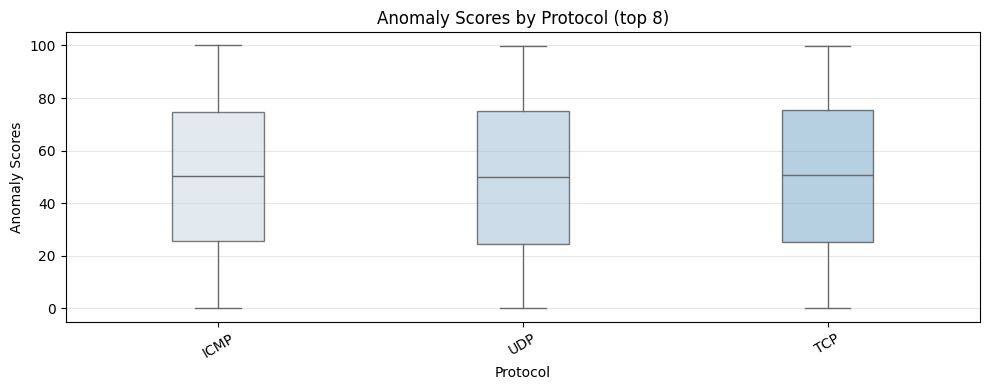

Saved: C:\repos\ml-cybersecurity_attacks\reports\anomaly_scores\anomaly_scores_by_protocol_boxplot.png


In [6]:
# Chart 4: Target distribution across a categorical (Protocol) if present

cat = 'Protocol'
if cat not in df.columns:
    print(f'Skipping: {cat} not present')
else:
    tmp = df[[cat, 'Anomaly Scores']].dropna()
    # Keep top protocols by count for readability.
    top = tmp[cat].value_counts().head(8).index
    tmp = tmp[tmp[cat].isin(top)]

    groups = [tmp.loc[tmp[cat].eq(v), 'Anomaly Scores'] for v in top]
    fig, ax = plt.subplots(figsize=(10, 4))
    bp = ax.boxplot(groups, labels=[str(v) for v in top], patch_artist=True)
    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(COLOR_PALLETE[i % len(COLOR_PALLETE)])
        patch.set_alpha(0.5)
    for element in ['whiskers', 'caps', 'medians']:
        for line in bp[element]:
            line.set_color(COLOR_PALLETE[-1])
    ax.set_title('Anomaly Scores by Protocol (top 8)')
    ax.set_xlabel('Protocol')
    ax.set_ylabel('Anomaly Scores')
    ax.tick_params(axis='x', rotation=30)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    out = REPORTS_DIR / 'anomaly_scores_by_protocol_boxplot.png'
    plt.savefig(out, dpi=160)
    plt.show()
    print(f'Saved: {out}')